## Import & Set Up

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Data"



Mounted at /content/drive
base_model.h5		       resnet_samplesize_model1.h5  vgg_1dropout.h5
densenet-100_sample.h5	       resnet_samplesize_model3.h5  vgg_3dropout.h5
densenet_2_dropout.h5	       resnet_withaug_model2_.h5    vgg_baseline.h5
densenet_img_aug.h5	       test			    vgg_imgaug.h5
model2.h5		       train			    vizgradcam
model_cnn_noaug_70%.h5	       unique_20_sample_test	    xception_main1.h5
model_weights_densenet_85%.h5  unique_20_sample_train	    xception_main.h5
resnet_dropout_model1.h5       unique_5_sample_test
resnet_dropout_model2.h5       unique_5_sample_train


In [ ]:
train_path = "/content/drive/My Drive/Data/train"
test_path = "/content/drive/My Drive/Data/test"

In [ ]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

## **Dropout Hypothesis**

## Densenet (0 dropout)

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=16,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=16,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)






predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_1dropout.h5", monitor='val_accuracy',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 90s 766ms/step - loss: 0.1223 - accuracy: 0.8258 - val_loss: 9.0092 - val_accuracy: 0.7125

Epoch 00001: val_accuracy improved from inf to 0.71250, saving model to densenet_1dropout.h5
Epoch 2/10
100/100 [==============================] - 72s 724ms/step - loss: 0.0703 - accuracy: 0.9112 - val_loss: 2.4199 - val_accuracy: 0.4400

Epoch 00002: val_accuracy improved from 0.71250 to 0.44000, saving model to densenet_1dropout.h5
Epoch 3/10
100/100 [==============================] - 72s 723ms/step - loss: 0.0703 - accuracy: 0.9194 - val_loss: 1.6083 - val_accuracy: 0.5925

Epoch 00003: val_accuracy did not improve from 0.44000
Epoch 4/10
100/100 [==============================] - 71s 702ms/step - loss: 0.0614 - accuracy: 0.9294 - val_loss: 0.4508 - val_accuracy: 0.8700

Epoch 00004: val_accuracy did not improve from 0.44000
Epoch 5/10
100/100 [==============================] - 70s 698ms/step - loss: 0.0674 - accuracy: 0.9194 - val_loss: 0

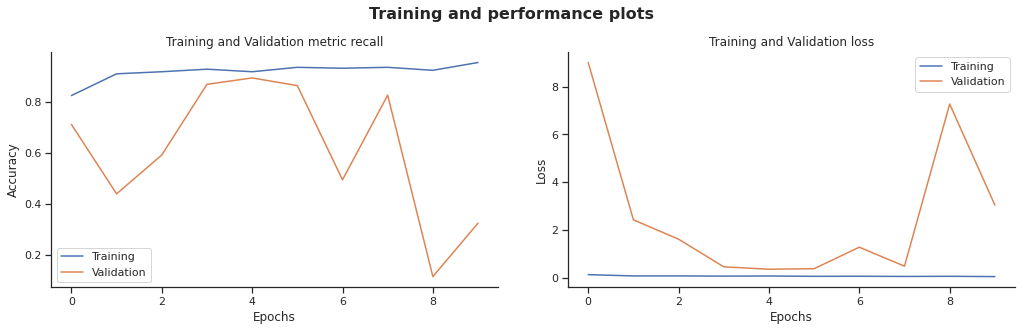

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

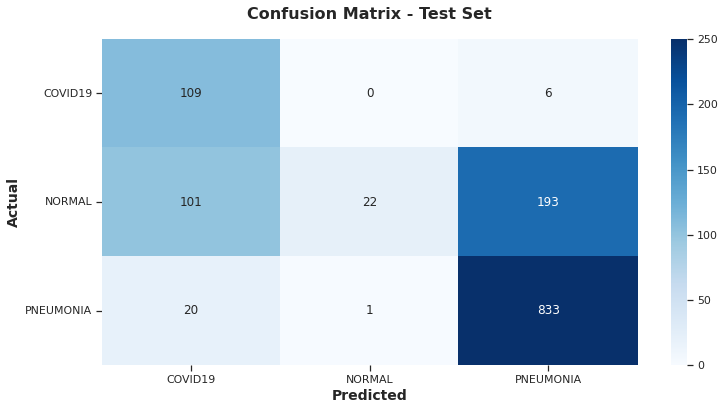

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 34s 413ms/step - loss: 1.1664 - accuracy: 0.7502


[1.1663652658462524, 0.7501945495605469]

In [ ]:
model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Densenet (1 dropout)

In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



train_datagen = ImageDataGenerator(
  rescale = 1./224, # standardization
  validation_split=0.001
)

test_datagen = ImageDataGenerator(rescale=1./224,
                                 validation_split=0.999)

train_gen = train_datagen.flow_from_directory(directory=train_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=16,
                                             color_mode="rgb")

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=16,
                                             color_mode="rgb")

Found 6028 images belonging to 3 classes.
Found 1285 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.50)(x)





predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_1dropout.h5", monitor='val_accuracy',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 87s 743ms/step - loss: 0.1315 - accuracy: 0.8352 - val_loss: 9.1036 - val_accuracy: 0.0450

Epoch 00001: val_loss improved from inf to 9.10359, saving model to densenet_1dropout.h5
Epoch 2/10
100/100 [==============================] - 70s 699ms/step - loss: 0.0929 - accuracy: 0.8869 - val_loss: 2.9101 - val_accuracy: 0.6950

Epoch 00002: val_loss improved from 9.10359 to 2.91011, saving model to densenet_1dropout.h5
Epoch 3/10
100/100 [==============================] - 72s 723ms/step - loss: 0.0861 - accuracy: 0.8850 - val_loss: 2.7551 - val_accuracy: 0.3200

Epoch 00003: val_loss improved from 2.91011 to 2.75506, saving model to densenet_1dropout.h5
Epoch 4/10
100/100 [==============================] - 73s 726ms/step - loss: 0.0887 - accuracy: 0.8950 - val_loss: 1.0942 - val_accuracy: 0.6075

Epoch 00004: val_loss improved from 2.75506 to 1.09417, saving model to densenet_1dropout.h5
Epoch 5/10
100/100 [============================

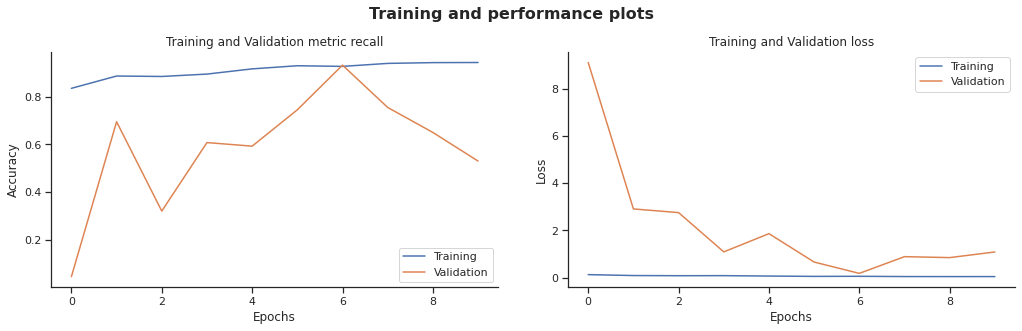

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

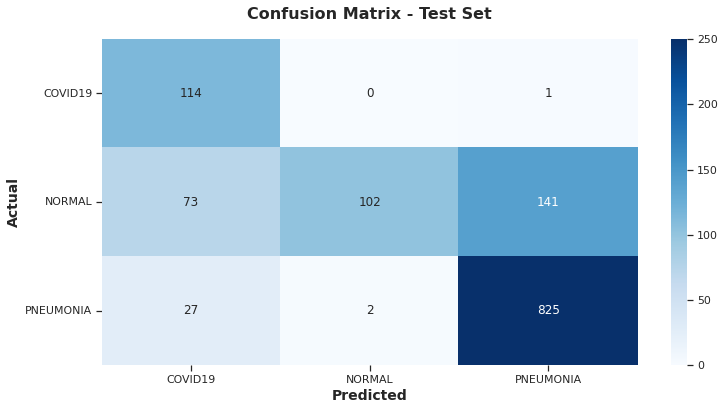

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 35s 428ms/step - loss: 0.4665 - accuracy: 0.8101


[0.46653443574905396, 0.810116708278656]

In [ ]:
model.save("densenet_1dropout.h5.h5")
from google.colab import files
files.download('densenet_1dropout.h5.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ***~ Base model for Hypo 2 and 3***

## densenet base model
> 86% before img aug


In [ ]:


classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)
batch_size = 16


img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 96s 824ms/step - loss: 0.1061 - accuracy: 0.8637 - val_loss: 2.8609 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 2.86089, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 78s 776ms/step - loss: 0.0765 - accuracy: 0.9062 - val_loss: 4.3471 - val_accuracy: 0.2075

Epoch 00002: val_loss did not improve from 2.86089
Epoch 3/10
100/100 [==============================] - 77s 771ms/step - loss: 0.0608 - accuracy: 0.9294 - val_loss: 0.1591 - val_accuracy: 0.9475

Epoch 00003: val_loss improved from 2.86089 to 0.15908, saving model to densenet_0dropout.h5
Epoch 4/10
100/100 [==============================] - 78s 781ms/step - loss: 0.0639 - accuracy: 0.9174 - val_loss: 3.1163 - val_accuracy: 0.7100

Epoch 00004: val_loss did not improve from 0.15908
Epoch 5/10
100/100 [==============================] - 78s 777ms/step - loss: 0.0622 - accuracy: 0.9219 - val_loss: 1.1873 - val_accu

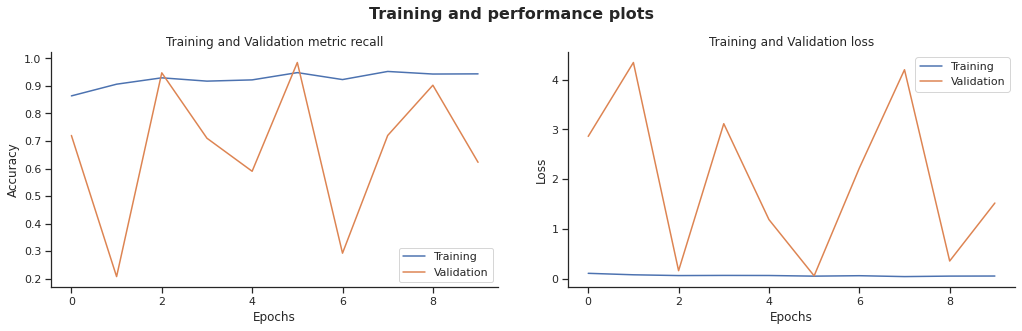

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

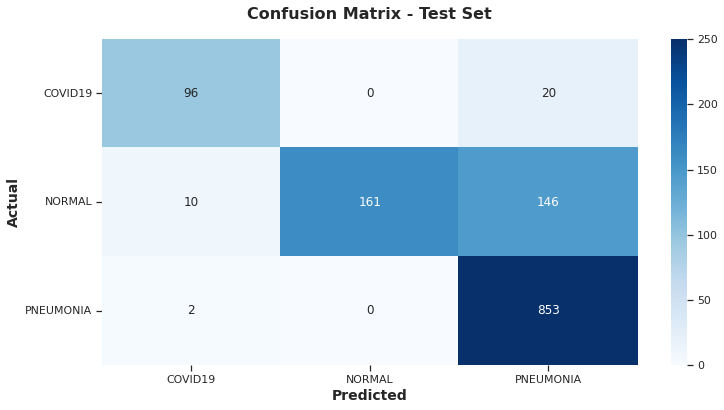

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 38s 466ms/step - loss: 0.5879 - accuracy: 0.8618


[0.5878607034683228, 0.861801266670227]

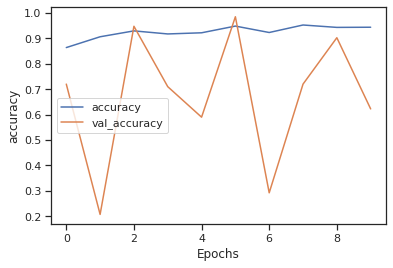

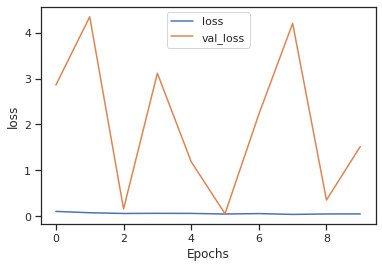

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

## **Sample Size Hypothesis**

## Small sample size: model run (20%)
> 66%

In [ ]:
train_path = "/content/drive/My Drive/Data/unique_20_sample_train"
test_path = "/content/drive/My Drive/Data/unique_20_sample_test"

In [ ]:
path = train_path
diag_code_dict = {
    'COVID19': 0,
    'NORMAL': 1,
    'PNEUMONIA': 2}

diag_title_dict = {
    'COVID19': 'Covid-19',
    'NORMAL': 'Healthy',
    'PNEUMONIA': 'Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

imageid_path_dict

{}

In [ ]:
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = len(classes)



img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224)

test_datagen = ImageDataGenerator(rescale = 1./224)

train_gen = train_datagen.flow_from_directory(directory = train_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_gen = test_datagen.flow_from_directory(directory = test_path,
                                                        target_size = tuple(img_size),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_path, 'COVID19')))

total = num_normal + num_pneumonia + num_covid
weight_for_0 = num_covid / total
weight_for_1 = num_normal / total
weight_for_2 = num_pneumonia / total
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=5,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight
)

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/5
76/76 [==============================] - 390s 5s/step - loss: 0.1096 - accuracy: 0.8573 - val_loss: 6.8673 - val_accuracy: 0.2529

Epoch 00001: val_loss improved from inf to 6.86729, saving model to densenet_0dropout.h5
Epoch 2/5
76/76 [==============================] - 47s 618ms/step - loss: 0.0802 - accuracy: 0.9012 - val_loss: 0.5909 - val_accuracy: 0.8132

Epoch 00002: val_loss improved from 6.86729 to 0.59091, saving model to densenet_0dropout.h5
Epoch 3/5
76/76 [==============================] - 47s 615ms/step - loss: 0.0626 - accuracy: 0.9195 - val_loss: 0.9926 - val_accuracy: 0.7510

Epoch 00003: val_loss did not improve from 0.59091
Epoch 4/5
76/76 [==============================] - 47s 614ms/step - loss: 0.0577 - accuracy: 0.9162 - val_loss: 0.7727 - val_accuracy: 0.7704

Epoch 00004: val_loss did not improve from 0.59091
Epoch 5/5
76/76 [==============================] - 47s 612ms/step - loss: 0.0581 

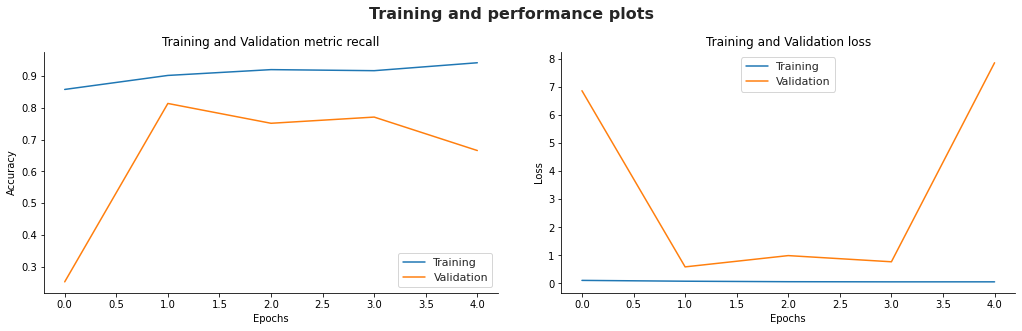

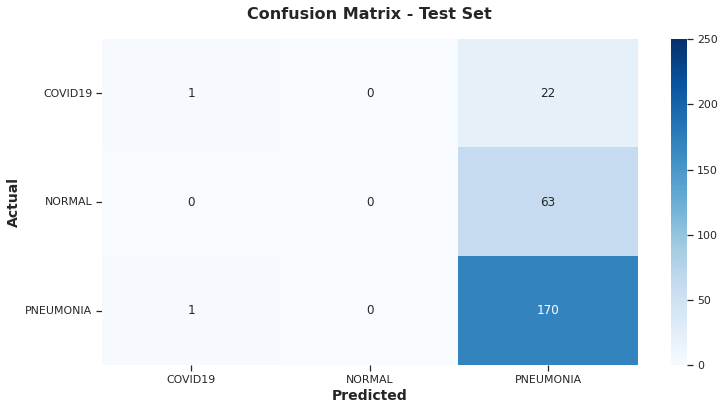

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

17/17 [==============================] - 8s 412ms/step - loss: 7.8630 - accuracy: 0.6654


[7.863019943237305, 0.6653696298599243]

## **Img Aug Hypothesis**

## Densenet hypo img aug 
> 89% after img aug


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D
)

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(128, activation="relu")(x)



predictions = Dense(3, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint("densenet_0dropout.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

r = model.fit(
    train_gen, 
    epochs=10,
    callbacks=[mc,es],
    validation_data=test_gen,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 412s 4s/step - loss: 0.2204 - accuracy: 0.6556 - val_loss: 12.7963 - val_accuracy: 0.2900

Epoch 00001: val_loss improved from inf to 12.79631, saving model to densenet_0dropout.h5
Epoch 2/10
100/100 [==============================] - 249s 2s/step - loss: 0.1764 - accuracy: 0.7312 - val_loss: 1.2668 - val_accuracy: 0.3000

Epoch 00002: val_loss improved from 12.79631 to 1.26679, saving model to densenet_0dropout.h5
Epoch 3/10
100/100 [==============================] - 215s 2s/step - loss: 0.1509 - accuracy: 0.7581 - val_loss: 3.8711 - val_accuracy: 0.2650

Epoch 00003: val_loss did not improve from 1.26679
Epoch 4/10
100/100 [==============================] - 170s 2s/step - loss: 0.1455 - accuracy: 0.8031 - val_loss: 2.2774 - val_accuracy: 0.0375

Epoch 00004: val_loss did not improve from 1.26679
Epoch 5/10
100/100 [==============================] - 166s 2s/step - loss: 0.1399 - accuracy: 0.7994 - val_loss: 0.3613 - val_accuracy: 0

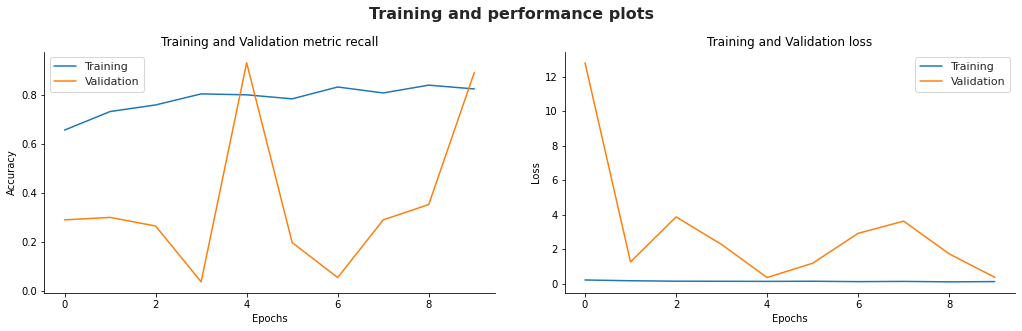

In [ ]:
y_pred = model.predict(test_gen)
fig, axarr = plt.subplots(1,2, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
history = r

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['accuracy'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_accuracy'], ax=axarr[0], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')


axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

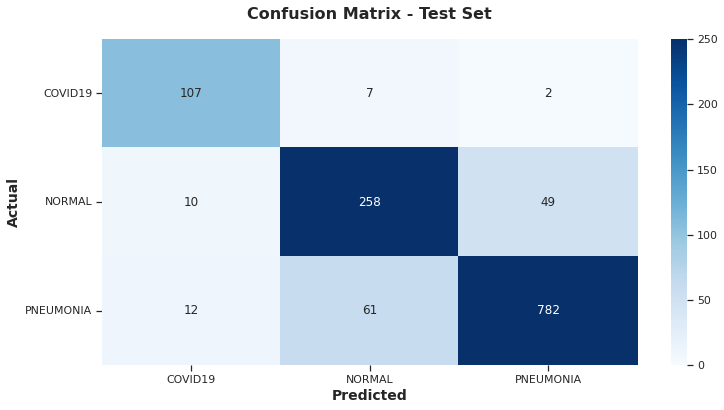

In [ ]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [ ]:
model.evaluate(train_gen)
model.evaluate(test_gen)

81/81 [==============================] - 39s 467ms/step - loss: 0.3037 - accuracy: 0.8905


[0.30367791652679443, 0.8905279636383057]

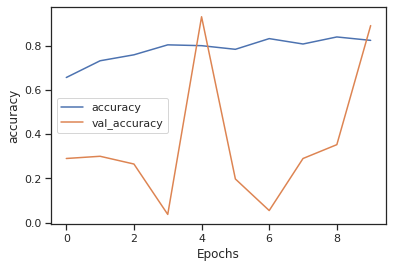

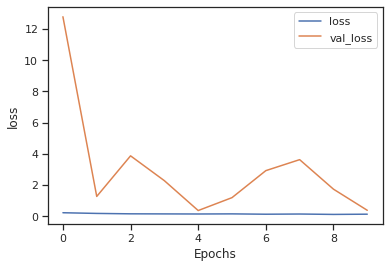

In [ ]:
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")